In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
#View all columns in measurements
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
#View all columns in station
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Save references to each table

measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent = session.query(measurement.date).\
    order_by(measurement.date.desc()).first()

recent.date

'2017-08-23'

Text(0.5, 1.0, 'Daily Count of Precipitation in Hawaii')

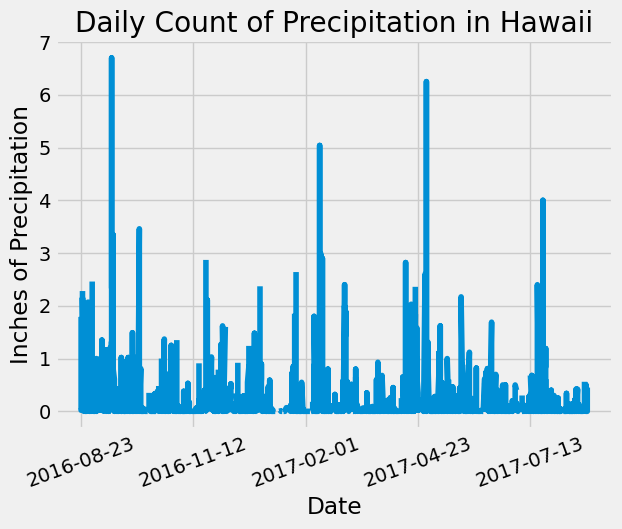

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
end_date = datetime.strptime("2017-08-23", "%Y-%m-%d").date()
start_date = end_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(measurement.date.desc(), measurement.prcp)\
    .filter(measurement.date.between(start_date, end_date)).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation, columns=["date", "prcp"])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by="date")
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(precipitation_df["date"],precipitation_df["prcp"])
plt.xticks(np.arange(0,365,81), rotation=20)
plt.xlabel("Date")
plt.ylabel("Inches of Precipitation")
plt.title("Daily Count of Precipitation in Hawaii")


In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
print(precipitation_df["prcp"].describe())

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
number_stations = session.query(station.station).count()
number_stations

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, 
                                 func.count(measurement.station)).\
                                 group_by(measurement.station).\
                                 order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
top_station_temp = session.query(func.min(measurement.tobs),
                                  func.max(measurement.tobs), 
                                  func.avg(measurement.tobs)).\
                                    filter(measurement.station == "USC00519281").all()
top_station_temp

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 1.0, 'Daily Temperature Frequency Count')

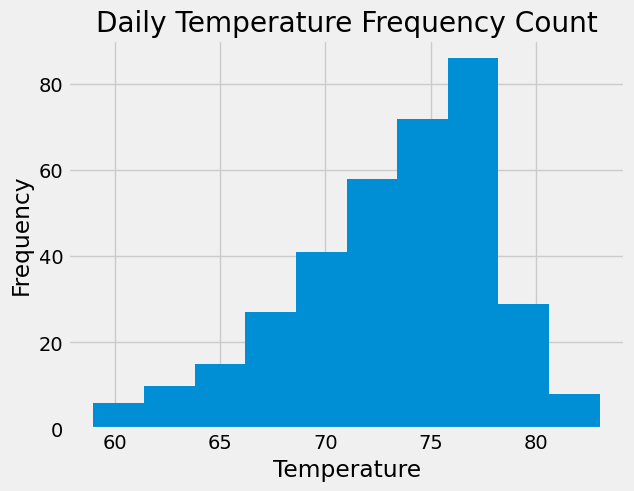

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_station_plot = session.query(measurement.tobs).\
    filter(measurement.station == "USC00519281").\
    filter(measurement.date.between(start_date, end_date)).all()

top_station_df = pd.DataFrame(top_station_plot, columns=["tobs"])

# Use Pandas Plotting with Matplotlib to plot the data
plt.hist(top_station_df["tobs"])
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Daily Temperature Frequency Count")

# Close Session

In [18]:
# Close Session
session.close()